In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pandas as pd
import numpy as np
import torch
import datetime
from tqdm import tqdm_notebook
from torch import nn
from torchvision import transforms
from cnn_finetune import make_model
from sklearn.model_selection import StratifiedKFold

import model2 as M
import unet_parts
from dataset import SegmentationDataset, SegmentationInferenceDataset
from data import *
from util import *
from loss import FocalLoss, dice_loss
from lovasz_loss import lovasz_hinge_flat, lovasz_hinge

In [3]:
torch.cuda.is_available()
device = torch.device('cuda')

In [4]:
# Settings
# ========

# Target k in KFold
CV = 0

# Skip pretraining
skip_pretraining = False

In [5]:
train_df, val_df = get_dfs_fold(k=CV)

train_dataset = SegmentationDataset(train_df, size=(128, 128),
                                    use_depth_channels=True,
                                    with_aux_label=True,
                                    as_aux_label='coverage_class',
                                    use_augmentation=True)
val_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128),
                                           use_depth_channels=True, with_aux_label=False, with_gt=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
print('Loaded dataset and created loader')

Use augmentations
Loaded dataset and created loader


# Training

In [6]:
gc.collect()
torch.cuda.empty_cache()

model = M.UNetRes34HcAuxSCSEv2(n_classes=1, n_aux_classes=8)
model = model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters())

Loaded pretrained resnet weights


In [7]:
def criterion_phase1(logit, logit_pixel, logit_aux, target_pixel, target_label):
    segmentation_loss = F.binary_cross_entropy_with_logits(logit.view(-1), target_pixel.view(-1), size_average=True)
    segmentation_dice_loss = dice_loss(logit, target_pixel)
    
    hc_loss = F.binary_cross_entropy_with_logits(logit_pixel.view(-1), target_pixel.view(-1), size_average=True)
    hc_dice_loss = dice_loss(logit_pixel, target_pixel)
    
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return 0.5 * segmentation_loss + 0.5 * segmentation_dice_loss + 0.1 * hc_loss + 0.1 * hc_dice_loss + 0.05 * classification_loss

In [8]:
def train_phase1(model, n_epoch, train_iter, val_iter):
    best_iou = 0.0
    n_stay = 0
    early_stopping_limit = 10
    
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_pixel, logit_aux = model(data)
            loss = criterion_phase1(logit, logit_pixel, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=True, threshold=0.5)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
        
        if best_iou < iou:
            best_iou = iou
            save_model(model, f'unet_res34_hcauxscsev2_aug_kfold_cv{CV}_phase1')
            print('Saved model at {} (IoU: {})'.format(epoch, iou))
            n_stay = 0
        else:
            n_stay += 1
        
        if n_stay >= early_stopping_limit:
            print('Early stopping at {} (Best IoU: {})'.format(epoch, best_iou))
            break
            
    return model

In [9]:
if not skip_pretraining:
    model = train_phase1(model, 50, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


[2018-10-16 17:39:45.339315] Train Epoch: 0 [0/3198 (0%)]	Average loss: 0.084035
[2018-10-16 17:40:07.632134] Train Epoch: 0 [600/3198 (19%)]	Average loss: 0.062397
[2018-10-16 17:40:29.922360] Train Epoch: 0 [1200/3198 (37%)]	Average loss: 0.057065
[2018-10-16 17:40:52.174178] Train Epoch: 0 [1800/3198 (56%)]	Average loss: 0.053437
[2018-10-16 17:41:14.326443] Train Epoch: 0 [2400/3198 (75%)]	Average loss: 0.051919
[2018-10-16 17:41:36.438890] Train Epoch: 0 [3000/3198 (94%)]	Average loss: 0.050190
[2018-10-16 17:41:36.438890] Train Epoch: 0	IoU: 0.546758
Saved model at 0 (IoU: 0.5467581047381546)
[2018-10-16 17:42:03.877436] Train Epoch: 1 [0/3198 (0%)]	Average loss: 0.035854
[2018-10-16 17:42:26.071530] Train Epoch: 1 [600/3198 (19%)]	Average loss: 0.041514
[2018-10-16 17:42:48.308034] Train Epoch: 1 [1200/3198 (37%)]	Average loss: 0.039972
[2018-10-16 17:43:10.559088] Train Epoch: 1 [1800/3198 (56%)]	Average loss: 0.039149
[2018-10-16 17:43:32.824416] Train Epoch: 1 [2400/3198 (75%

[2018-10-16 18:10:07.505492] Train Epoch: 13 [3000/3198 (94%)]	Average loss: 0.019320
[2018-10-16 18:10:07.505492] Train Epoch: 13	IoU: 0.754364
Saved model at 13 (IoU: 0.7543640897755611)
[2018-10-16 18:10:27.333618] Train Epoch: 14 [0/3198 (0%)]	Average loss: 0.045474
[2018-10-16 18:10:49.588385] Train Epoch: 14 [600/3198 (19%)]	Average loss: 0.018822
[2018-10-16 18:11:11.804758] Train Epoch: 14 [1200/3198 (37%)]	Average loss: 0.019310
[2018-10-16 18:11:34.020596] Train Epoch: 14 [1800/3198 (56%)]	Average loss: 0.018963
[2018-10-16 18:11:56.249930] Train Epoch: 14 [2400/3198 (75%)]	Average loss: 0.018888
[2018-10-16 18:12:18.493297] Train Epoch: 14 [3000/3198 (94%)]	Average loss: 0.019372
[2018-10-16 18:12:18.493297] Train Epoch: 14	IoU: 0.735661
[2018-10-16 18:12:37.984068] Train Epoch: 15 [0/3198 (0%)]	Average loss: 0.020875
[2018-10-16 18:13:00.202266] Train Epoch: 15 [600/3198 (19%)]	Average loss: 0.019969
[2018-10-16 18:13:22.424557] Train Epoch: 15 [1200/3198 (37%)]	Average los

[2018-10-16 18:40:37.439753] Train Epoch: 27 [3000/3198 (94%)]	Average loss: 0.012096
[2018-10-16 18:40:37.439753] Train Epoch: 27	IoU: 0.757481
[2018-10-16 18:40:57.013061] Train Epoch: 28 [0/3198 (0%)]	Average loss: 0.010829
[2018-10-16 18:41:19.244702] Train Epoch: 28 [600/3198 (19%)]	Average loss: 0.012303
[2018-10-16 18:41:41.530477] Train Epoch: 28 [1200/3198 (37%)]	Average loss: 0.011406
[2018-10-16 18:42:03.752860] Train Epoch: 28 [1800/3198 (56%)]	Average loss: 0.011002
[2018-10-16 18:42:25.966549] Train Epoch: 28 [2400/3198 (75%)]	Average loss: 0.010995
[2018-10-16 18:42:48.172980] Train Epoch: 28 [3000/3198 (94%)]	Average loss: 0.010995
[2018-10-16 18:42:48.172980] Train Epoch: 28	IoU: 0.742269
[2018-10-16 18:43:07.721041] Train Epoch: 29 [0/3198 (0%)]	Average loss: 0.013274
[2018-10-16 18:43:29.929743] Train Epoch: 29 [600/3198 (19%)]	Average loss: 0.012465
[2018-10-16 18:43:52.065329] Train Epoch: 29 [1200/3198 (37%)]	Average loss: 0.012448
[2018-10-16 18:44:14.311001] Tra

[2018-10-16 19:11:38.564952] Train Epoch: 42 [0/3198 (0%)]	Average loss: 0.004920
[2018-10-16 19:12:00.799515] Train Epoch: 42 [600/3198 (19%)]	Average loss: 0.007309
[2018-10-16 19:12:22.989814] Train Epoch: 42 [1200/3198 (37%)]	Average loss: 0.006908
[2018-10-16 19:12:45.252638] Train Epoch: 42 [1800/3198 (56%)]	Average loss: 0.006825
[2018-10-16 19:13:07.486589] Train Epoch: 42 [2400/3198 (75%)]	Average loss: 0.007002
[2018-10-16 19:13:29.737207] Train Epoch: 42 [3000/3198 (94%)]	Average loss: 0.007029
[2018-10-16 19:13:29.737207] Train Epoch: 42	IoU: 0.777681
Early stopping at 42 (Best IoU: 0.780423940149626)


In [10]:
def criterion_phase2(logit, logit_pixel, logit_aux, target_pixel, target_label):
    segmentation_loss = lovasz_hinge(logit.squeeze(), target_pixel.squeeze())
    hc_loss = lovasz_hinge(logit_pixel.squeeze(), target_pixel.squeeze())
    classification_loss = F.cross_entropy(logit_aux, target_label)
    
    return segmentation_loss + 0.1 * hc_loss + 0.05 * classification_loss

In [11]:
def train_phase2(model, n_epoch, train_iter, val_iter):
    best_iou = 0.0
    n_stay = 0
    early_stopping_limit = 10
    
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit, logit_pixel, logit_aux = model(data)
            loss = criterion_phase2(logit, logit_pixel, logit_aux, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=False, threshold=0.0)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
        
        if best_iou < iou:
            best_iou = iou
            save_model(model, f'unet_res34_hcauxscsev2_aug_kfold_cv{CV}_phase2')
            print('Saved model at {} (IoU: {})'.format(epoch, iou))
            n_stay = 0
        else:
            n_stay += 1
        
        if n_stay >= early_stopping_limit:
            print('Early stopping at {} (Best IoU: {})'.format(epoch, best_iou))
            break
            
    return model

In [12]:
model = train_phase2(model, 60, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


[2018-10-16 19:13:49.796888] Train Epoch: 0 [0/3198 (0%)]	Average loss: 0.127720
[2018-10-16 19:14:14.870314] Train Epoch: 0 [600/3198 (19%)]	Average loss: 0.120029
[2018-10-16 19:14:39.857291] Train Epoch: 0 [1200/3198 (37%)]	Average loss: 0.110110
[2018-10-16 19:15:04.859347] Train Epoch: 0 [1800/3198 (56%)]	Average loss: 0.103728
[2018-10-16 19:15:29.854757] Train Epoch: 0 [2400/3198 (75%)]	Average loss: 0.097885
[2018-10-16 19:15:54.846239] Train Epoch: 0 [3000/3198 (94%)]	Average loss: 0.095534
[2018-10-16 19:15:54.846239] Train Epoch: 0	IoU: 0.748005
Saved model at 0 (IoU: 0.7480049875311722)
[2018-10-16 19:16:15.635049] Train Epoch: 1 [0/3198 (0%)]	Average loss: 0.066445
[2018-10-16 19:16:40.611538] Train Epoch: 1 [600/3198 (19%)]	Average loss: 0.080589
[2018-10-16 19:17:05.657380] Train Epoch: 1 [1200/3198 (37%)]	Average loss: 0.074745
[2018-10-16 19:17:30.679186] Train Epoch: 1 [1800/3198 (56%)]	Average loss: 0.075334
[2018-10-16 19:17:55.671453] Train Epoch: 1 [2400/3198 (75%

[2018-10-16 19:48:12.830217] Train Epoch: 14 [600/3198 (19%)]	Average loss: 0.038407
[2018-10-16 19:48:37.847358] Train Epoch: 14 [1200/3198 (37%)]	Average loss: 0.042813
[2018-10-16 19:49:02.851605] Train Epoch: 14 [1800/3198 (56%)]	Average loss: 0.041855
[2018-10-16 19:49:27.846618] Train Epoch: 14 [2400/3198 (75%)]	Average loss: 0.042739
[2018-10-16 19:49:52.803291] Train Epoch: 14 [3000/3198 (94%)]	Average loss: 0.043682
[2018-10-16 19:49:52.803291] Train Epoch: 14	IoU: 0.803242
Saved model at 14 (IoU: 0.8032418952618454)
[2018-10-16 19:50:13.564635] Train Epoch: 15 [0/3198 (0%)]	Average loss: 0.031235
[2018-10-16 19:50:38.578551] Train Epoch: 15 [600/3198 (19%)]	Average loss: 0.042850
[2018-10-16 19:51:03.555099] Train Epoch: 15 [1200/3198 (37%)]	Average loss: 0.039008
[2018-10-16 19:51:28.580538] Train Epoch: 15 [1800/3198 (56%)]	Average loss: 0.040388
[2018-10-16 19:51:53.686272] Train Epoch: 15 [2400/3198 (75%)]	Average loss: 0.040157
[2018-10-16 19:52:18.753389] Train Epoch: 1

[2018-10-16 20:22:11.517755] Train Epoch: 28 [600/3198 (19%)]	Average loss: 0.038627
[2018-10-16 20:22:36.433767] Train Epoch: 28 [1200/3198 (37%)]	Average loss: 0.038640
[2018-10-16 20:23:01.426850] Train Epoch: 28 [1800/3198 (56%)]	Average loss: 0.038697
[2018-10-16 20:23:26.476753] Train Epoch: 28 [2400/3198 (75%)]	Average loss: 0.037912
[2018-10-16 20:23:51.493682] Train Epoch: 28 [3000/3198 (94%)]	Average loss: 0.036991
[2018-10-16 20:23:51.493682] Train Epoch: 28	IoU: 0.789900
[2018-10-16 20:24:11.931857] Train Epoch: 29 [0/3198 (0%)]	Average loss: 0.018521
[2018-10-16 20:24:36.972541] Train Epoch: 29 [600/3198 (19%)]	Average loss: 0.033269
[2018-10-16 20:25:01.968446] Train Epoch: 29 [1200/3198 (37%)]	Average loss: 0.031066
[2018-10-16 20:25:26.975893] Train Epoch: 29 [1800/3198 (56%)]	Average loss: 0.031041
[2018-10-16 20:25:52.018207] Train Epoch: 29 [2400/3198 (75%)]	Average loss: 0.032883
[2018-10-16 20:26:17.028689] Train Epoch: 29 [3000/3198 (94%)]	Average loss: 0.034166
[

In [13]:
val_check_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), with_gt=True, with_raw_input=True, use_depth_channels=True)
val_check_loader = torch.utils.data.DataLoader(val_check_dataset, batch_size=8, shuffle=False)
val_check_iter = iter(val_check_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


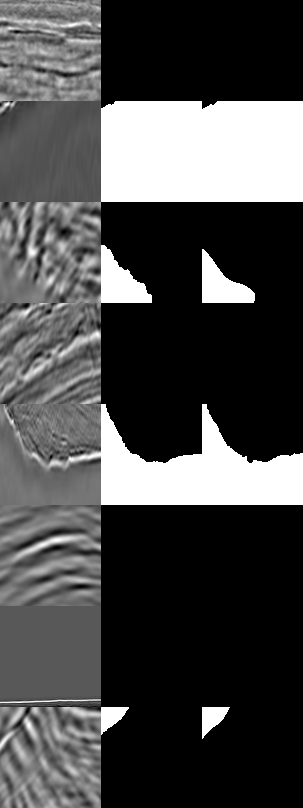

In [14]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=True, threshold=0.5)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


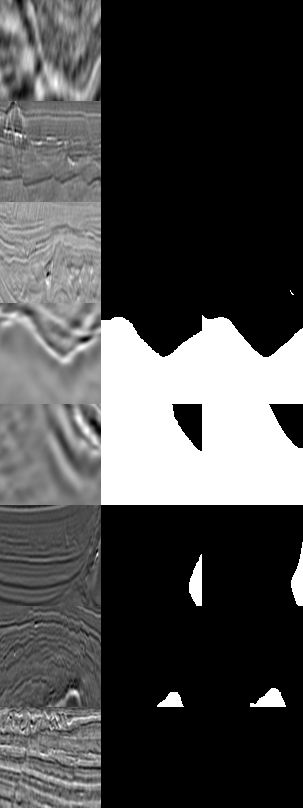

In [15]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


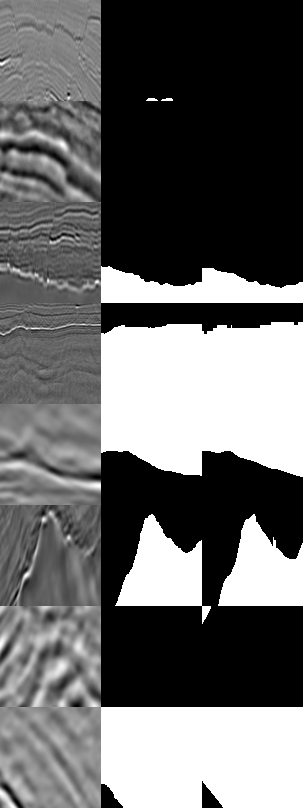

In [16]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


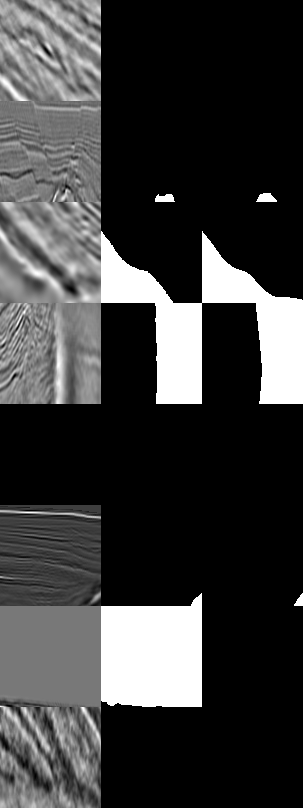

In [17]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)